# Slides for 2018-06-22 Meeting

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.scRNAseq import fe_tsne, raw_data, norm_data
from larval_gonad.normalization import tpm, rpkm

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force/')

last updated: 2018-06-22 
Git hash: ee2f194108e3170c6c9864f32ee7350a3ccb5e71


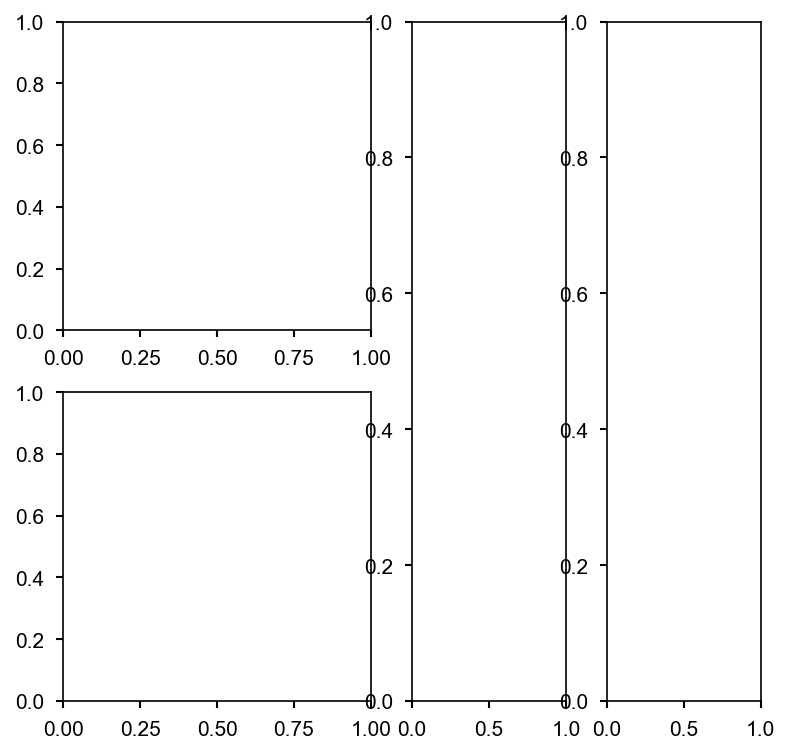

In [3]:
gs = plt.GridSpec(2, 3, width_ratios=[2, 1, 1])
axDia = plt.subplot(gs[0, 0])
axTsne = plt.subplot(gs[1, 0])
axAll = plt.subplot(gs[:, 1])
axDiff = plt.subplot(gs[:, 2])


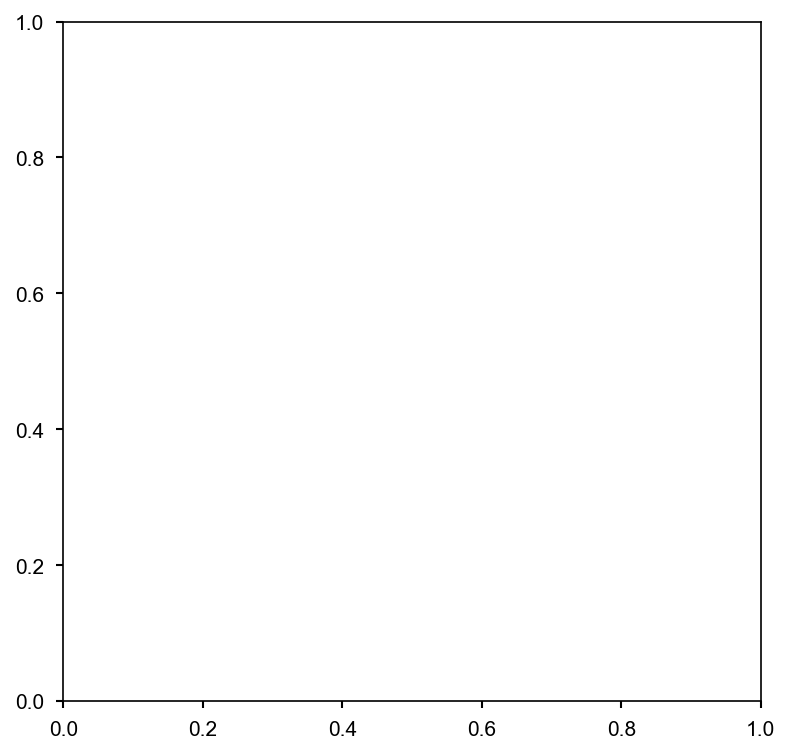

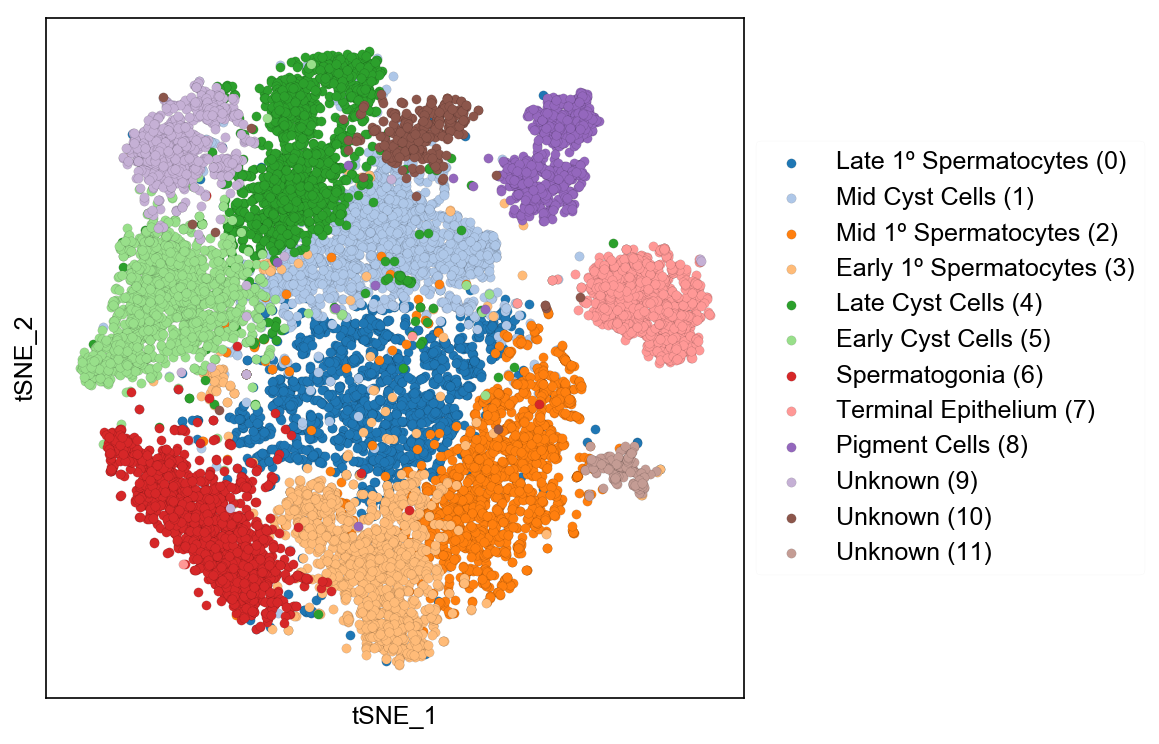

In [6]:
fe_tsne(seurat_dir=nbconfig.seurat_dir)

## Build large data table.

In [105]:
writer = pd.ExcelWriter('../output/2018-06-22_biomarkers_and_cnts_tables.xlsx')

In [106]:
cell_format = writer.book.add_format({'valign': 'top'})
cell_format.set_text_wrap()

In [107]:
sheet = writer.book.add_worksheet('README')
writer.sheets['README'] = sheet

In [108]:
comment = """\
Each cluster is on a separate worksheet. Genes with missing counts were not captured by the experiment. 
"""

In [109]:
sheet.set_column(0, 0, width=30, cell_format=cell_format)
sheet.set_column(1, 1, width=50, cell_format=cell_format)
sheet.set_row(0, height=50, cell_format=cell_format)
sheet.merge_range('A1:C1', comment);

In [110]:
col_desc = {
    'FBgn': 'FlyBase Gene ID',
    'gene_symbol': 'Gene Symbol', 
    'chrom': 'Chromosomal Arm',
    'p_val': 'Seurat FindMarkers p-value', 
    'p_val_adj': 'FDR Adjusted p-value', 
    'avg_logFC': 'Average log Fold Change', 
    'Prop Cells in Cluster 0': 'Proportion of Cells in cluster 0 with gene expressed.',
    'Prop Cells in Other Clusters': 'Proportion of Cells in all other clusters with gene expressed.', 
    'Total Read Cnts': 'Sum of raw read counts across cells',
    'Median Scaled Read Cnts': 'Sum of raw read counts across cells scaled by median total read count across genes', 
    'TPM Read Cnts': 'TPM normalized read count', 
    'RPKM Read Cnts': 'RPKM normalized read count',
}

_desc = pd.Series(col_desc).to_frame()
_desc.index.name = 'Column Name'
_desc.columns = ['Column Description']
_desc.to_excel(writer, sheet_name='README', startrow=1)

In [111]:
# Gene annotation with symbols
gene_annot = pd.Series(nbconfig.fbgn2symbol)
gene_annot.name = 'gene_symbol'
gene_annot = gene_annot.to_frame().join(nbconfig.fbgn2chrom)

In [112]:
# Biomarkers
biomarker = nbconfig.seurat.get_biomarkers('res.0.6')
biomarker.drop('gene_symbol', axis=1, inplace=True)

In [113]:
for g, dd in biomarker.groupby('cluster'):
    raw = raw_data(nbconfig.seurat_dir, cluster=g)

    total_cnts = raw.sum(axis=1)
    total_cnts.name = 'Total Read Cnts'

    scaled_cnts = total_cnts / total_cnts.median()
    scaled_cnts.name = 'Median Scaled Read Cnts'

    gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col='FBgn').gene_ts_length
    tpm_cnts = tpm(total_cnts.to_frame(), gene_lens).dropna().iloc[:, 0]
    tpm_cnts.name = 'TPM Read Cnts'

    rpkm_cnts = rpkm(total_cnts.to_frame(), gene_lens).dropna().iloc[:, 0]
    rpkm_cnts.name = 'RPKM Read Cnts'

    bio = dd.drop('cluster', axis=1)[['p_val', 'p_val_adj', 'avg_logFC', 'pct.1', 'pct.2']]
    bio.rename({'pct.1': f'Per Cells in Cluster {g}', 'pct.2': 'Per Cells in Other Clusters'}, axis=1, inplace=True)
    _dat = gene_annot.join(bio, how='left').join([total_cnts, scaled_cnts, tpm_cnts, rpkm_cnts], how='left')
    _dat.index.name = 'FBgn'
    _dat.set_index(['gene_symbol', 'chrom'], append=True, inplace=True)
    _dat.to_excel(writer, sheet_name=f'{nbconfig.CLUSTER_ANNOT[g]}')

In [114]:
writer.save()